We set target vol to 10% per annum to ensure fair return (and bc it is also the case in the paper)
Without rescaling, a strategy with higher volatility would naturally dominate the P&L simply because it takes bigger bets. By scaling everything to 10% volatility, we equalize the risk budget. If one strategy makes more money than another after this scaling, it is because it is more efficient (higher Sharpe Ratio), not just riskier

Pool of Strategies: ['CAR', 'VAL', 'M1M', 'M3M', 'M6M', 'M1Y', 'VOL', 'SKEW', 'KURT']

--- Strategy Performance Statistics ---
              Ann. Mean  Ann. Vol    Sharpe
Naive          0.102182  0.105024  0.972935
Mean           0.082924  0.106092  0.781627
Volatility     0.106154  0.107024  0.991870
Sharpe         0.087026  0.107863  0.806817
Top-3          0.096361  0.112459  0.856851
Max Return     0.122489  0.144972  0.844914
Min Variance   0.106700  0.143205  0.745089


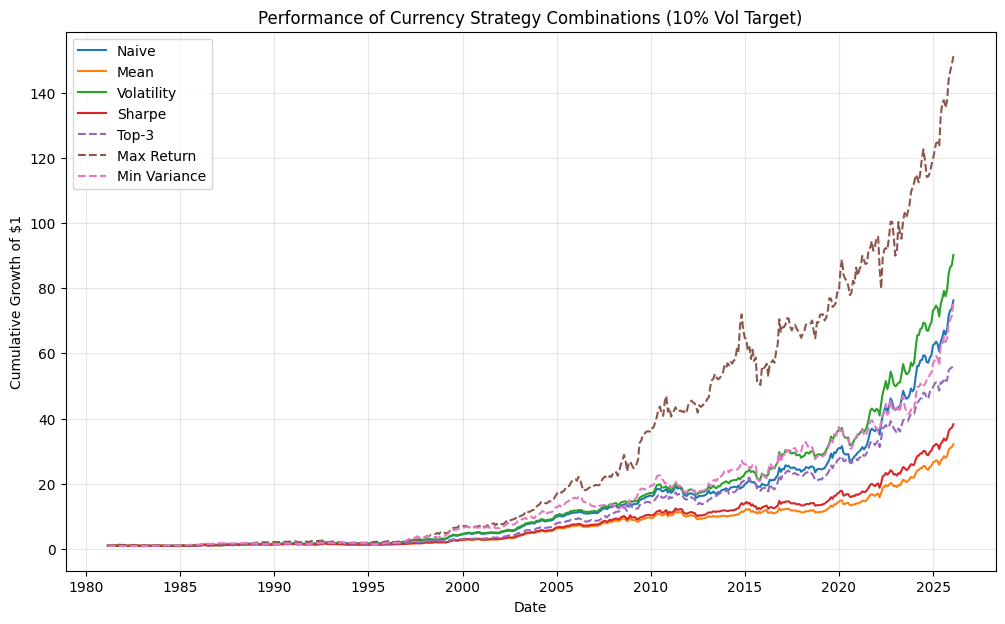

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize



df = pd.read_excel('../data/Factors_Net.xlsx')


if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df.set_index('date', inplace=True)


strategies = ['CAR', 'VAL', 'M1M', 'M3M',
                'M6M', 'M1Y', 'VOL', 'SKEW', 'KURT']

# Filter for columns that actually exist in the file
available_strategies = [col for col in strategies if col in df.columns]
print(f"Pool of Strategies: {available_strategies}")

returns = df[available_strategies].dropna()
    
target_vol_ann = 0.10
target_vol_m = target_vol_ann / np.sqrt(12)
window = 60  # 5-year rolling window

# Storage
# We will store the *returns* of each combined strategy
combined_results = pd.DataFrame(index=returns.index[window:],
                                columns=['Naive', 'Mean', 'Volatility', 'Sharpe',
                                            'Top-3', 'Max Return', 'Min Variance'])

# Rolling Window Loop
for t in range(window, len(returns)):
    # Data available up to t-1
    past_returns = returns.iloc[t-window:t]

    # --- Inputs for Optimization ---
    mu = past_returns.mean()
    sigma = past_returns.cov()
    inv_sigma = np.linalg.pinv(sigma)  # Pseudo-inverse for stability
    vols = np.sqrt(np.diag(sigma))

    w_naive = np.ones(len(available_strategies)) / \
        len(available_strategies)

    # --- 2. Mean Combination ---
    w_mean = mu.values

    # --- 3. Volatility Combination (Inverse Vol) ---
    w_vol = 1.0 / vols

    # --- 4. Sharpe Combination (Heuristic) ---
    with np.errstate(divide='ignore', invalid='ignore'):
        w_sharpe_h = mu.values / vols
        w_sharpe_h[~np.isfinite(w_sharpe_h)] = 0.0

    # --- 5. Top-3 Combination ---
    # Calculate historical Sharpe for ranking
    hist_sharpe = mu / vols
    # Get indices of top 3
    top3_indices = hist_sharpe.nlargest(3).index
    # Create weight vector
    w_top3 = pd.Series(0.0, index=available_strategies)
    w_top3[top3_indices] = 1.0 / 3.0  # Equal weight to top 3
    w_top3 = w_top3.values

    # --- 6. Maximum Return (Mean-Variance) ---
    # Maximize Returns s.t. Vol = Target
    # Analytical solution: w proportional to Sigma^-1 * Mu
    w_maxret = inv_sigma @ mu.values

    # --- 7. Minimum Variance ---
    # Minimize Variance s.t. Sum(w)=1
    # Analytical solution: w proportional to Sigma^-1 * 1
    ones = np.ones(len(available_strategies))
    w_minvar = inv_sigma @ ones
    w_minvar = w_minvar / np.sum(w_minvar)  # Normalize to sum to 1

    # --- Volatility Scaling & Return Calculation ---
    # Apply scaling to ALL strategies to meet target volatility

    weight_dict = {
        'Naive': w_naive,
        'Mean': w_mean,
        'Volatility': w_vol,
        'Sharpe': w_sharpe_h,
        'Top-3': w_top3,
        'Max Return': w_maxret,
        'Min Variance': w_minvar
    }

    r_t = returns.iloc[t]  # Realized return for this month

    for name, w_raw in weight_dict.items():
        # Calculate ex-ante portfolio vol
        p_var = w_raw @ sigma @ w_raw.T
        p_vol = np.sqrt(p_var)

        # Scale weights
        if p_vol > 0:
            scaler = target_vol_m / p_vol
            w_final = w_raw * scaler
        else:
            w_final = w_raw

        # Store realized return
        combined_results.loc[returns.index[t],
                                name] = np.dot(w_final, r_t.values)

# 3. Statistics & Plotting
# ---------------------------------------------------------
combined_results = combined_results.apply(pd.to_numeric)

# Calculate Stats
def get_stats(series):
    ann_mean = series.mean() * 12
    ann_vol = series.std() * np.sqrt(12)
    sharpe = ann_mean / ann_vol if ann_vol != 0 else 0
    return pd.Series({'Ann. Mean': ann_mean, 'Ann. Vol': ann_vol, 'Sharpe': sharpe})

stats_df = combined_results.apply(get_stats)
print("\n--- Strategy Performance Statistics ---")
print(stats_df.T)  # Transpose for readability

# Plot
cumulative = (1 + combined_results).cumprod()

plt.figure(figsize=(12, 7))
for col in cumulative.columns:
    # Use dashed lines for the new strategies to distinguish
    style = '--' if col in ['Top-3', 'Max Return', 'Min Variance'] else '-'
    plt.plot(cumulative.index, cumulative[col], label=col, linestyle=style)

plt.title('Performance of Currency Strategy Combinations (10% Vol Target)')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth of $1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


--- Strategy Performance Statistics ---
                 Ann. Mean  Ann. Vol    Sharpe   Sortino
Naive             0.108962  0.111607  0.976306  1.668789
Mean              0.088244  0.113907  0.774699  1.249026
Volatility        0.111730  0.112433  0.993752  1.714199
Sharpe            0.091061  0.114374  0.796172  1.293591
Top-3             0.098535  0.115300  0.854595  1.449179
Max Return        0.103880  0.116451  0.892046  1.537796
Min Variance      0.108188  0.118604  0.912181  1.593546
Downside Parity   0.112060  0.114695  0.977027  1.673066


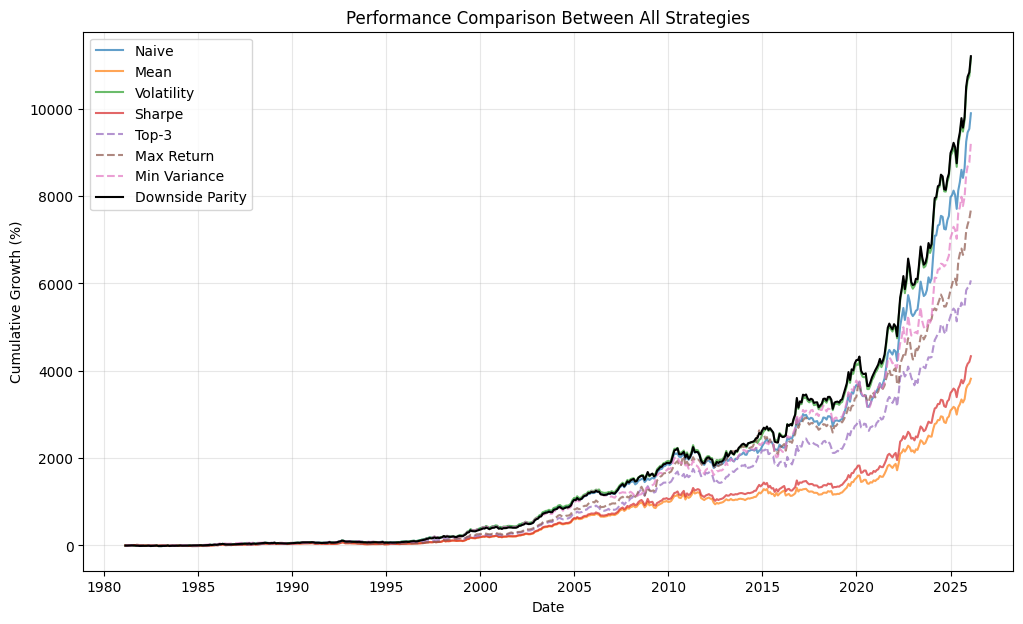

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf

# 1. Load Data
# ---------------------------------------------------------
try:
    df = pd.read_excel('../data/Factors_Net.xlsx')

    # Parse dates
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
        df.set_index('date', inplace=True)

    # Strategies to combine
    strategies = ['CAR', 'VAL', 'M1M', 'M3M',
                  'M6M', 'M1Y', 'VOL', 'SKEW', 'KURT']
    available_strategies = [col for col in strategies if col in df.columns]
    returns = df[available_strategies].dropna()

except Exception as e:
    print(f"Error loading data: {e}")
    returns = pd.DataFrame()

# 2. Strategy Logic
# ---------------------------------------------------------
if not returns.empty:
    # Parameters
    target_vol_ann = 0.10
    target_vol_m = target_vol_ann / np.sqrt(12)
    window = 60  # 5-year rolling window

    # Risk-free rate (CHANGE if needed)
    rf_ann = 0.0
    rf_m = rf_ann / 12

    # Storage
    cols = ['Naive', 'Mean', 'Volatility', 'Sharpe', 'Top-3',
            'Max Return', 'Min Variance', 'Downside Parity']
    combined_results = pd.DataFrame(index=returns.index[window:], columns=cols)

    # Rolling Window Loop
    for t in range(window, len(returns)):
        past_returns = returns.iloc[t-window:t]

        # --- Standard Estimates ---
        mu = past_returns.mean()

        # Covariance (Ledoit-Wolf)
        lw = LedoitWolf()
        try:
            lw.fit(past_returns)
            sigma = lw.covariance_
        except:
            sigma = past_returns.cov().values

        inv_sigma = np.linalg.pinv(sigma)
        vols = np.sqrt(np.diag(sigma))

        # --- Downside Estimates ---
        neg_rets = past_returns.copy()
        neg_rets[neg_rets > 0] = 0
        semi_vols = np.sqrt((neg_rets**2).mean())
        semi_vols[semi_vols == 0] = 1e-6

        # --- 1. Naive (1/N) ---
        w_naive = np.ones(len(available_strategies)) / \
            len(available_strategies)

        # --- 2. Mean ---
        w_mean = mu.values

        # --- 3. Volatility (Risk Parity) ---
        w_vol = 1.0 / vols

        # --- 4. Sharpe ---
        with np.errstate(divide='ignore', invalid='ignore'):
            w_sharpe = mu.values / vols
            w_sharpe[~np.isfinite(w_sharpe)] = 0.0

        # --- 5. Top-3 (Momentum) ---
        hist_sharpe = mu / vols
        top3_indices = hist_sharpe.nlargest(3).index
        w_top3 = pd.Series(0.0, index=available_strategies)
        idx_map = {name: i for i, name in enumerate(available_strategies)}
        for name in top3_indices:
            w_top3.iloc[idx_map[name]] = 1.0 / 3.0
        w_top3 = w_top3.values

        # --- 6. Max Return (MV) ---
        w_maxret = inv_sigma @ mu.values

        # --- 7. Min Variance ---
        ones = np.ones(len(available_strategies))
        w_minvar = inv_sigma @ ones
        w_minvar = w_minvar / np.sum(w_minvar)

        # --- 8. Downside Risk Parity ---
        w_downside = 1.0 / semi_vols.values

        # --- Volatility Scaling & Return Calculation ---
        weight_dict = {
            'Naive': w_naive,
            'Mean': w_mean,
            'Volatility': w_vol,
            'Sharpe': w_sharpe,
            'Top-3': w_top3,
            'Max Return': w_maxret,
            'Min Variance': w_minvar,
            'Downside Parity': w_downside
        }

        r_t = returns.iloc[t]

        for name, w_raw in weight_dict.items():
            p_var = w_raw @ sigma @ w_raw.T
            p_vol = np.sqrt(p_var)

            if p_vol > 0:
                scaler = target_vol_m / p_vol
                w_final = w_raw * scaler
            else:
                w_final = w_raw

            combined_results.loc[returns.index[t],
                                 name] = np.dot(w_final, r_t.values)

    # 3. Statistics & Plotting
    # ---------------------------------------------------------
    combined_results = combined_results.apply(pd.to_numeric)

    def get_stats(series):
        # Excess returns
        excess = series - rf_m

        # Annualized mean excess return
        ann_mean = excess.mean() * 12

        # Annualized volatility
        ann_vol = series.std() * np.sqrt(12)

        # Sharpe
        sharpe = ann_mean / ann_vol if ann_vol != 0 else 0

        # --- Sortino ---
        downside = excess.copy()
        downside[downside > 0] = 0

        downside_dev_m = np.sqrt((downside**2).mean())
        downside_dev_ann = downside_dev_m * np.sqrt(12)

        sortino = ann_mean / downside_dev_ann if downside_dev_ann != 0 else 0

        return pd.Series({
            'Ann. Mean': ann_mean,
            'Ann. Vol': ann_vol,
            'Sharpe': sharpe,
            'Sortino': sortino
        })

    stats_df = combined_results.apply(get_stats)
    print("\n--- Strategy Performance Statistics ---")
    print(stats_df.T)

    # Plot % Cumulative Growth
    cumulative = (1 + combined_results).cumprod()
    cumulative_pct = (cumulative - 1) * 100

    plt.figure(figsize=(12, 7))
    for col in cumulative_pct.columns:
        if col == 'Downside Parity':
            plt.plot(cumulative_pct.index,
                     cumulative_pct[col], label=col, color='black')
        else:
            style = '--' if col in ['Top-3',
                                    'Max Return', 'Min Variance'] else '-'
            plt.plot(cumulative_pct.index,
                     cumulative_pct[col], label=col, linestyle=style, alpha=0.7)

    plt.title('Performance Comparison Between All Strategies')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Growth (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [3]:
stats_df.T.sort_values(by='Sharpe').to_excel("../data/results_stats_combination.xlsx")

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. Load the datasets
universe = "All"
portfolios = pd.read_excel(f"../data/Portfolios_Net_CAR.xlsx")
factors = pd.read_excel(f"../data/Factors_Net.xlsx")

# Clean and align dates
portfolios['date'] = pd.to_datetime(portfolios['date'], format='%Y%m%d')
factors['date'] = pd.to_datetime(factors['date'], format='%Y%m%d')
portfolios.set_index('date', inplace=True)
factors.set_index('date', inplace=True)

# Merge to ensure exact date alignment
data = portfolios[['P1', 'P2', 'P3', 'P4', 'P5']].dropna().join(
    factors[['DOL', 'CAR']].dropna(), how='inner')

port_cols = ['P1', 'P2', 'P3', 'P4', 'P5']
factor_cols = ['DOL', 'CAR']

# ==========================================
# STAGE 1: Time-Series Regressions (Estimate Betas)
# ==========================================
betas = []
X_ts = sm.add_constant(data[factor_cols])

for port in port_cols:
    y_ts = data[port]
    model_ts = sm.OLS(y_ts, X_ts).fit()
    # Store the betas (ignoring the intercept)
    betas.append(model_ts.params[factor_cols].values)

# Create a DataFrame of betas (Rows: Portfolios, Cols: DOL, CAR)
beta_df = pd.DataFrame(betas, columns=factor_cols, index=port_cols)
print("--- Stage 1: Estimated Betas ---")
print(beta_df)
print("\n")

# ==========================================
# STAGE 2: Cross-Sectional Regressions (Estimate Risk Premia)
# ==========================================
# Note: In FX factor models using a Dollar factor, the intercept is often dropped
# in the cross-section because the DOL portfolio essentially captures the base level.
# We will run it with a constant here for standard statistical evaluation.

lambdas = []
X_cs = sm.add_constant(beta_df)

for t in data.index:
    y_cs = data.loc[t, port_cols].values
    model_cs = sm.OLS(y_cs, X_cs).fit()
    lambdas.append(model_cs.params)

lambda_df = pd.DataFrame(lambdas, index=data.index)

# Calculate final risk premia (mean of lambdas) and t-statistics
risk_premia = lambda_df.mean()
risk_premia_stderr = lambda_df.std() / np.sqrt(len(lambda_df))
t_stats = risk_premia / risk_premia_stderr

# Print Summary Statistics
summary_fmb = pd.DataFrame({
    'Risk Premium (\u03bb) Monthly': risk_premia,
    'Risk Premium (\u03bb) Annualized': risk_premia * 12,
    'Std Error': risk_premia_stderr,
    't-stat': t_stats
})

print("--- Stage 2: Fama-MacBeth Risk Premia Estimates ---")
print(summary_fmb)

--- Stage 1: Estimated Betas ---
         DOL       CAR
P1  0.999662 -0.394309
P2  0.947175 -0.140236
P3  0.998028 -0.010262
P4  1.062395  0.038260
P5  0.999662  0.605691


--- Stage 2: Fama-MacBeth Risk Premia Estimates ---
       Risk Premium (λ) Monthly  Risk Premium (λ) Annualized  Std Error  \
const                 -0.003713                    -0.044555   0.004619   
DOL                    0.004848                     0.058175   0.004690   
CAR                    0.006275                     0.075294   0.000877   

         t-stat  
const -0.803794  
DOL    1.033622  
CAR    7.152191  


In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. Définir l'univers et charger les données
portfolios = pd.read_excel(f"../data/Portfolios_Net_CAR.xlsx")
factors = pd.read_excel(f"../data/Factors_Net.xlsx")
grvol = pd.read_excel("../data/GRVOL.xlsx")

# 2. Nettoyer les dates et les convertir en périodes mensuelles (Année-Mois)
portfolios['date'] = pd.to_datetime(portfolios['date'], format='%Y%m%d')
factors['date'] = pd.to_datetime(factors['date'], format='%Y%m%d')
grvol['date'] = pd.to_datetime(grvol['date'], format='%Y%m%d')

portfolios['Month'] = portfolios['date'].dt.to_period('M')
factors['Month'] = factors['date'].dt.to_period('M')
grvol['Month'] = grvol['date'].dt.to_period('M')

# Définir le mois comme index
portfolios.set_index('Month', inplace=True)
factors.set_index('Month', inplace=True)
grvol.set_index('Month', inplace=True)

# 3. Calculer la différence première du log de la volatilité
grvol = grvol.sort_index()
grvol['d_log_vol'] = np.log(grvol['vol']).diff()

# 4. Fusionner toutes les séries (l'intersection 'inner' garde uniquement les mois communs)
data = portfolios[['P1', 'P2', 'P3', 'P4', 'P5']].join(
    factors[['DOL', 'CAR']], how='inner'
).join(
    grvol[['d_log_vol']], how='inner'
).dropna()

port_cols = ['P1', 'P2', 'P3', 'P4', 'P5']
factor_cols = ['DOL', 'CAR', 'd_log_vol']

# ==========================================
# ETAPE 1 : Régressions Temporelles (Estimation des Bêtas)
# ==========================================
betas = []
X_ts = sm.add_constant(data[factor_cols])

for port in port_cols:
    y_ts = data[port]
    model_ts = sm.OLS(y_ts, X_ts).fit()
    betas.append(model_ts.params[factor_cols].values)

beta_df = pd.DataFrame(betas, columns=factor_cols, index=port_cols)
print("--- Etape 1 : Bêtas Estimés ---")
print(beta_df)
print("\n")

--- Etape 1 : Bêtas Estimés ---
         DOL       CAR  d_log_vol
P1  0.999345 -0.395110  -0.000243
P2  0.948535 -0.136794   0.001043
P3  1.002180  0.000244   0.003183
P4  1.057597  0.026117  -0.003679
P5  0.999345  0.604890  -0.000243




In [6]:
# ==========================================
# ETAPE 2 : Régressions Transversales (Estimation des Primes de Risque)
# ==========================================
lambdas = []
X_cs = sm.add_constant(beta_df)

for t in data.index:
    y_cs = data.loc[t, port_cols].values
    model_cs = sm.OLS(y_cs, X_cs).fit()
    lambdas.append(model_cs.params)

lambda_df = pd.DataFrame(lambdas, index=data.index)

# Calculer les primes de risque finales (moyenne des lambdas) et les t-stats de Fama-MacBeth
risk_premia = lambda_df.mean()
risk_premia_stderr = lambda_df.std() / np.sqrt(len(lambda_df))
t_stats = risk_premia / risk_premia_stderr

# Afficher les statistiques récapitulatives
summary_fmb = pd.DataFrame({
    'Prime de Risque (\u03bb) Mensuelle': risk_premia,
    'Prime de Risque (\u03bb) Annualisée': risk_premia * 12,
    'Erreur Standard': risk_premia_stderr,
    't-stat': t_stats
})

print("--- Etape 2 : Estimations des Primes de Risque (Fama-MacBeth) ---")
print(summary_fmb)

--- Etape 2 : Estimations des Primes de Risque (Fama-MacBeth) ---
           Prime de Risque (λ) Mensuelle  Prime de Risque (λ) Annualisée  \
const                           0.000675                        0.008106   
DOL                             0.000467                        0.005600   
CAR                             0.006283                        0.075400   
d_log_vol                      -0.121654                       -1.459852   

           Erreur Standard    t-stat  
const             0.006310  0.107047  
DOL               0.006359  0.073385  
CAR               0.000877  7.160494  
d_log_vol         0.093238 -1.304775  


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# On s'assure que le DataFrame est bien trié chronologiquement
df_master = df_master.sort_index()

# Identifier les 30 portefeuilles
portfolios = [col for col in df_master.columns if col.startswith('P')]

# Paramètres de la fenêtre glissante
window = 60 # 60 mois = 5 ans
lambdas_rolling = []
dates_rolling = []

# Boucle Fama-MacBeth avec fenêtre glissante
for t in range(window, len(df_master)):
    
    train_data = df_master.iloc[t-window : t]
    test_data = df_master.iloc[t]
    
    # --- Étape 1 : Régressions Temporelles (Estimation des Betas sur la fenêtre) ---
    X_ts = sm.add_constant(train_data[['DOL', 'CAR', 'd_log_vol']])
    betas_t = pd.DataFrame(index=portfolios, columns=['beta_DOL', 'beta_CAR', 'beta_VOL'])
    
    for port in portfolios:
        model_ts = sm.OLS(train_data[port], X_ts).fit()
        betas_t.loc[port, 'beta_DOL'] = model_ts.params['DOL']
        betas_t.loc[port, 'beta_CAR'] = model_ts.params['CAR']
        betas_t.loc[port, 'beta_VOL'] = model_ts.params['d_log_vol']
    
    betas_t = betas_t.astype(float)
    
    # ==========================================
    # NOUVEAU : Standardisation Transversale (Z-score)
    # ==========================================
    beta_vol_mean = betas_t['beta_VOL'].mean()
    beta_vol_std = betas_t['beta_VOL'].std()
    
    if beta_vol_std != 0:
        betas_t['beta_VOL_z'] = (betas_t['beta_VOL'] - beta_vol_mean) / beta_vol_std
    else:
        betas_t['beta_VOL_z'] = betas_t['beta_VOL']
        
    # --- Étape 2 : Régression Transversale (Estimation des primes de risque au mois t) ---
    # On utilise beta_VOL_z à la place du beta_VOL brut
    X_cs = betas_t[['beta_DOL', 'beta_CAR', 'beta_VOL_z']]
    y_t = test_data[portfolios].astype(float)
    
    # Fit OLS SANS constante
    model_cs = sm.OLS(y_t, X_cs).fit()
    
    lambdas_rolling.append(model_cs.params)
    dates_rolling.append(df_master.index[t])

# ==========================================
# ÉTAPE 3 : Moyennes de Fama-MacBeth
# ==========================================
lambdas_df = pd.DataFrame(lambdas_rolling, index=dates_rolling)

fm_estimates = lambdas_df.mean()
fm_se = lambdas_df.std() / np.sqrt(len(lambdas_df))
fm_tstats = fm_estimates / fm_se

results = pd.DataFrame({
    'Risk Premium (Ann. %)': fm_estimates * 12 * 100,
    'Std Error (Ann. %)': fm_se * 12 * 100,
    't-stat': fm_tstats
})

print("--- Rolling Window (60-month) Factor Prices of Risk (Standardized VOL) ---")
print(results)

NameError: name 'df_master' is not defined